<a href="https://colab.research.google.com/github/CarolKogei/google-notebooks-dl/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries required for the project
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import itertools
import random
import shutil
import glob
import cv2
import os

import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

# Loading data into the notebook

* Dividing dataset into train, val and test data sets

In [ ]:
database_path = "/content/drive/MyDrive/folder_group/"
dataset_path = "/content/drive/MyDrive/model_data/"
species = os.listdir(database_path)
for specie in species:
  imgs = os.listdir(database_path+specie)
  random.shuffle(imgs)
  imgs = imgs[:500] 
  train = imgs[:int(0.7*len(imgs))]
  validate = imgs[int(0.7*len(imgs)):int(0.7*len(imgs)+0.2*len(imgs))]
  test = imgs[int(-0.1*len(imgs)):]
  #print(len(train),len(validate), len(test))

  dataset = [[train, "train"], [validate, "validate"], [test, "test"]]

  #copy files from top_ten dirs to respective dirs
  for folder in dataset:
    os.makedirs(dataset_path+folder[1]+"/"+specie)
    for img in folder[0]:
      source_path = database_path+specie+"/"+img
      dest_path = dataset_path+folder[1]+"/"+specie+"/"+img
      
      shutil.copyfile(source_path, dest_path)

* sample of a beetle image

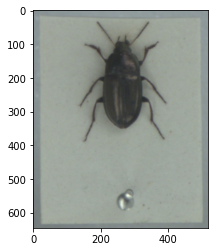

In [ ]:
img = plt.imread('/content/drive/MyDrive/model_data/train/1035185/d158s0001.jpg')
plt.imshow(img)

# Feature transfer

## Data Pre-processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_path = '/content/drive/MyDrive/model_data/train'
validate_path ='/content/drive/MyDrive/model_data/validate'
test_path ='/content/drive/MyDrive/model_data/test'


# train dataset
train_generator = train_datagen.flow_from_directory(train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    classes = ['1035195','1035864','1035931','1036216','4475140','5755079','7508714','9364935','4474169','1035185'])

validation_generator = validation_datagen.flow_from_directory(validate_path, target_size=(224,224), batch_size=32, class_mode='categorical',classes = ['1035195','1035864','1035931','1036216','4475140','5755079','7508714','9364935','4474169','1035185'] )
test_generator = test_datagen.flow_from_directory(test_path, target_size=(224,224),batch_size=32,classes = ['1035195','1035864','1035931','1036216','4475140','5755079','7508714','9364935','4474169','1035185'])


Found 3500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


* Displaying a pre-processed test data
* Ran into an error displaying generated images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The 'shape' parameter of imshow() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'shape', they should be pass as keyword, not positionally.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:706: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


ValueError: ignored

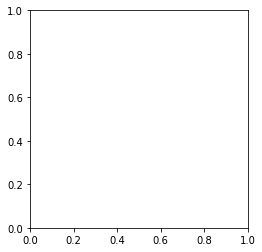

In [ ]:
plt.imshow(test_generator[0], shape=(224,224,3))
plt.show()

## Instantiating mobilenetv2 model



* Defining the image size and shape

In [ ]:
image_size = 224
image_shape = (image_size,image_size,3)


* Create base model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=None,alpha=1.0,include_top=False,weights="imagenet",input_tensor=None,pooling=max)

* Summary of the model

In [ ]:
base_model.summary()

NameError: ignored

* Set trainable layers to false



In [ ]:
base_model.trainable = False

* Create a functional model

In [ ]:
model_seq = tf.keras.Sequential([
                        base_model,
keras.layers.GlobalAveragePooling2D(),
keras.layers.Dense(10, activation='sigmoid')])

* Summary of the functional model

In [ ]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


* Compiling the mode

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


* Fitting the model

In [ ]:
history = model_seq.fit(train_generator,steps_per_epoch = 10,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 [==============================] - 538s 58s/step - loss: 2.5038 - accuracy: 0.1125 - val_loss: 2.4138 - val_accuracy: 0.1350
Epoch 2/10
10/10 [==============================] - 132s 13s/step - loss: 2.2925 - accuracy: 0.1875 - val_loss: 2.3554 - val_accuracy: 0.1520
Epoch 3/10
10/10 [==============================] - 119s 12s/step - loss: 2.3425 - accuracy: 0.1533 - val_loss: 2.3020 - val_accuracy: 0.1470
Epoch 4/10
10/10 [==============================] - 108s 11s/step - loss: 2.1963 - accuracy: 0.2125 - val_loss: 2.2573 - val_accuracy: 0.1730
Epoch 5/10
10/10 [==============================] - 101s 10s/step - loss: 2.1965 - accuracy: 0.1906 - val_loss: 2.2221 - val_accuracy: 0.1840
Epoch 6/10
10/10 [==============================] - 100s 10s/step - loss: 2.1774 - accuracy: 0.2062 - val_loss: 2.1863 - val_accuracy: 0.1970
Epoch 7/10
10/10 [==============================] - 91s 9s/step - loss: 2.1236 - accuracy: 0.2313 - val_loss: 2.1502 - val_accuracy: 0.2080
Epoch 8/

* The model performed poorly wirh accuracis of 15% and 14% for testing and validation datasets

**Run 2**

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Changed the optimizer to 'Adam' 

In [ ]:
history1 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
110/110 [==============================] - 519s 5s/step - loss: 1.8607 - accuracy: 0.3609 - val_loss: 1.7968 - val_accuracy: 0.3720
Epoch 2/10
110/110 [==============================] - 115s 1s/step - loss: 1.6077 - accuracy: 0.4871 - val_loss: 1.6251 - val_accuracy: 0.4330
Epoch 3/10
110/110 [==============================] - 113s 1s/step - loss: 1.4480 - accuracy: 0.5500 - val_loss: 1.4986 - val_accuracy: 0.4950
Epoch 4/10
110/110 [==============================] - 108s 981ms/step - loss: 1.3255 - accuracy: 0.5926 - val_loss: 1.4073 - val_accuracy: 0.5310
Epoch 5/10
110/110 [==============================] - 108s 979ms/step - loss: 1.2318 - accuracy: 0.6183 - val_loss: 1.3403 - val_accuracy: 0.5480
Epoch 6/10
110/110 [==============================] - 108s 976ms/step - loss: 1.1698 - accuracy: 0.6429 - val_loss: 1.2787 - val_accuracy: 0.5730
Epoch 7/10
110/110 [==============================] - 107s 974ms/step - loss: 1.1078 - accuracy: 0.6606 - val_loss: 1.2152 - val_accu

**Run 3**

* Increase learning rate to 0.01

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history2 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
 26/110 [======>.......................] - ETA: 14:13 - loss: 1.8670 - accuracy: 0.3522

* plotting accuracies and losses

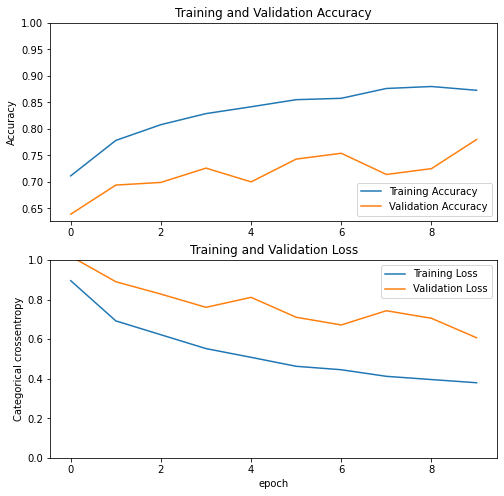

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

Here,we unfreeze some layers of the base model to achieve an optimal base model

In [ ]:
base_model.trainable=True

* Number of layers in the model

In [ ]:
len(base_model.layers)

154

* Freeze the first 100 layers

In [ ]:
for layer in base_model.layers[:100]:
  layer.trainable=False

* Compile the model

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


* Summary of the model

In [ ]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 1,874,250
Non-trainable params: 396,544
_________________________________________________________________


* Number of layers being trained

In [ ]:
len(model_seq.trainable_variables)

56

* Training the model

**Run 1**

In [ ]:
history3 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
110/110 [==============================] - 174s 2s/step - loss: 0.7123 - accuracy: 0.7751 - val_loss: 26.5574 - val_accuracy: 0.1140
Epoch 2/10
110/110 [==============================] - 170s 2s/step - loss: 0.2289 - accuracy: 0.9217 - val_loss: 18.1310 - val_accuracy: 0.2380
Epoch 3/10
110/110 [==============================] - 169s 2s/step - loss: 0.1568 - accuracy: 0.9454 - val_loss: 17.7061 - val_accuracy: 0.3160
Epoch 4/10
110/110 [==============================] - 169s 2s/step - loss: 0.1736 - accuracy: 0.9434 - val_loss: 21.9385 - val_accuracy: 0.1400
Epoch 5/10
110/110 [==============================] - 170s 2s/step - loss: 0.1386 - accuracy: 0.9511 - val_loss: 25.2241 - val_accuracy: 0.1850
Epoch 6/10
110/110 [==============================] - 169s 2s/step - loss: 0.0999 - accuracy: 0.9629 - val_loss: 17.1616 - val_accuracy: 0.2500
Epoch 7/10
110/110 [==============================] - 169s 2s/step - loss: 0.0925 - accuracy: 0.9711 - val_loss: 7.9194 - val_accuracy: 

* Change the learning rate because of increase in trainable layers

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Run 2**

In [ ]:
history4 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
110/110 [==============================] - 183s 2s/step - loss: 1.1473 - accuracy: 0.6780 - val_loss: 42.8839 - val_accuracy: 0.2000
Epoch 2/10
110/110 [==============================] - 181s 2s/step - loss: 0.3646 - accuracy: 0.8814 - val_loss: 54.3288 - val_accuracy: 0.1240
Epoch 3/10
110/110 [==============================] - 182s 2s/step - loss: 0.3270 - accuracy: 0.8949 - val_loss: 37.1870 - val_accuracy: 0.1780
Epoch 4/10
110/110 [==============================] - 181s 2s/step - loss: 0.3015 - accuracy: 0.9003 - val_loss: 80.9262 - val_accuracy: 0.1000
Epoch 5/10
110/110 [==============================] - 181s 2s/step - loss: 0.1890 - accuracy: 0.9366 - val_loss: 50.7727 - val_accuracy: 0.1010
Epoch 6/10
110/110 [==============================] - 181s 2s/step - loss: 0.2043 - accuracy: 0.9311 - val_loss: 45.0077 - val_accuracy: 0.1050
Epoch 7/10
110/110 [==============================] - 179s 2s/step - loss: 0.1782 - accuracy: 0.9437 - val_loss: 66.1055 - val_accuracy:

* Smaller learning rates are better, so make the learning rate smaller and retrain the whole model

**Run 3**

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history5 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
110/110 [==============================] - 1467s 13s/step - loss: 0.8628 - accuracy: 0.7134 - val_loss: 1.4331 - val_accuracy: 0.5230
Epoch 2/10
110/110 [==============================] - 240s 2s/step - loss: 0.2443 - accuracy: 0.9257 - val_loss: 1.6030 - val_accuracy: 0.5640
Epoch 3/10
110/110 [==============================] - 240s 2s/step - loss: 0.1325 - accuracy: 0.9603 - val_loss: 1.6990 - val_accuracy: 0.5650
Epoch 4/10
110/110 [==============================] - 240s 2s/step - loss: 0.0888 - accuracy: 0.9726 - val_loss: 1.6540 - val_accuracy: 0.5780
Epoch 5/10
110/110 [==============================] - 239s 2s/step - loss: 0.0622 - accuracy: 0.9831 - val_loss: 1.6425 - val_accuracy: 0.5960
Epoch 6/10
110/110 [==============================] - 240s 2s/step - loss: 0.0454 - accuracy: 0.9846 - val_loss: 1.6337 - val_accuracy: 0.6570
Epoch 7/10
110/110 [==============================] - 239s 2s/step - loss: 0.0316 - accuracy: 0.9926 - val_loss: 1.4736 - val_accuracy: 0.67

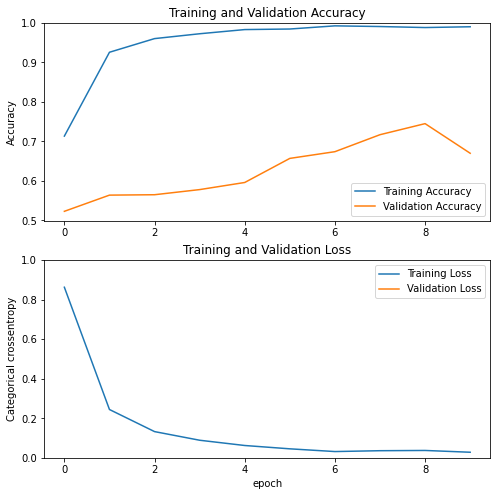

In [ ]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical crossentropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Run 4**

In [ ]:
for layer in base_model.layers[:120]:
  layer.trainable=False

* Changing the activation function to softmax

In [ ]:
model_seq = tf.keras.Sequential([
                        base_model,
keras.layers.GlobalAveragePooling2D(),
keras.layers.Dense(10, activation='softmax')])

* Compiling model

In [ ]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

* Fitting the model

In [ ]:
history6 = model_seq.fit(train_generator,validation_data=validation_generator,epochs=10)

Epoch 1/10
110/110 [==============================] - 202s 2s/step - loss: 0.2375 - accuracy: 0.9249 - val_loss: 84.7677 - val_accuracy: 0.1080
Epoch 2/10
110/110 [==============================] - 197s 2s/step - loss: 0.2056 - accuracy: 0.9280 - val_loss: 56.0126 - val_accuracy: 0.1890
Epoch 3/10
110/110 [==============================] - 197s 2s/step - loss: 0.1959 - accuracy: 0.9291 - val_loss: 43.1453 - val_accuracy: 0.1960
Epoch 4/10
110/110 [==============================] - 197s 2s/step - loss: 0.1799 - accuracy: 0.9389 - val_loss: 36.2769 - val_accuracy: 0.2060
Epoch 5/10
110/110 [==============================] - 197s 2s/step - loss: 0.1731 - accuracy: 0.9386 - val_loss: 24.2067 - val_accuracy: 0.2720
Epoch 6/10
110/110 [==============================] - 197s 2s/step - loss: 0.1690 - accuracy: 0.9411 - val_loss: 22.1259 - val_accuracy: 0.2210
Epoch 7/10
110/110 [==============================] - 198s 2s/step - loss: 0.1442 - accuracy: 0.9471 - val_loss: 19.0814 - val_accuracy:

# Hyper-tuning of Parameters

* Installing keras_tuner

In [ ]:
pip install -q -U keras-tuner


     |████████████████████████████████| 98 kB 3.7 MB/s 


* Importing keras_tuner module

In [ ]:
import keras_tuner as kt

* Recalling our model

In [ ]:
len(base_model.layers)

154

In [ ]:
model_seq = tf.keras.Sequential([
                        base_model,
keras.layers.GlobalAveragePooling2D(),
keras.layers.Dense(10, activation='softmax')])

* Defining the hypermodel builder function

In [ ]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential model
  model_seq = tf.keras.Sequential([
                        base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(10, activation='softmax')])    

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model_seq.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model_seq

* Instantiating the tuner and tuning hype-parameters

In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir', # directory to save logs 
project_name='khyperband')

* Checking hypertuning settings

In [ ]:
tuner.search_space_summary() 

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


* Searching the best hyperparameter

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(train_generator, epochs=5, validation_data=validation_datagen)


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.0001            |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


InvalidArgumentError: ignored

In [ ]:
best_hp=tuner.get_best_hyperparameters()[0]

* Rebuilding and Training the Model with optimal hyperparameters

In [ ]:
Rebuilding and Training the Model with optimal hyperparameters

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()
h_model.fit(x_train, x_test, epochs=10, validation_split=0.2)